In [1]:
from collections import Counter

import torch
from torch.utils.data import DataLoader
from torchvision.models import EfficientNet_B1_Weights, efficientnet_b1

from conformal_prediction import (
    calculate_thresholds,
    get_calibration_scores,
    predict_conformal_set,
    softmax_conformal_score,
)
from constants import IMAGENET_CLASSES_DICT
from datasets import (
    get_class,
    get_imagenet_dataset,
    split_data,
)
from model_utils import (
    LatentModel,
    get_latent_classes,
)
from plot_utils import plot_experiment_results, plot_classes_tsne
from utils import (
    get_top_k,
    name_mapping_fn,
)

In [2]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
IMAGENET_PATH = "datasets"
BATCH_SIZE = 128

In [3]:
model_name = "efficientnet_b1"
model = efficientnet_b1(weights=EfficientNet_B1_Weights.IMAGENET1K_V1).to(DEVICE)
transform = EfficientNet_B1_Weights.IMAGENET1K_V1.transforms()

In [4]:
classifier = model.classifier
model.classifier = torch.nn.Identity()
model = LatentModel(model, classifier).to(DEVICE)

In [5]:
dataset = get_imagenet_dataset(IMAGENET_PATH, transform=transform)
test_dataset, calibrate_dataset = split_data(dataset, 0.02)

## Calibration

In [6]:
calibrate_loader = DataLoader(calibrate_dataset, batch_size=BATCH_SIZE, shuffle=False)

calibration_scores = get_calibration_scores(
    model, calibrate_loader, softmax_conformal_score, DEVICE
)

calib_len = len(calibration_scores)

100%|██████████| 8/8 [00:22<00:00,  2.87s/it]


## Conformal Prediction

In [35]:
CLASS = 935
ALPHA_TO_TEST = [0.01, 0.025, 0.04, 0.05, 0.1, 0.2]

In [36]:
save_path = f"plots/{name_mapping_fn(CLASS).replace(' ', '_')}"

class_subset = get_class(test_dataset, CLASS)
class_loader = DataLoader(class_subset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Class {CLASS}: {IMAGENET_CLASSES_DICT[CLASS]}")
print(f"Number of images: {len(class_subset)}")

Class 935: mashed potato
Number of images: 49


In [37]:
counters = {}
for alpha in ALPHA_TO_TEST:
    counter = Counter()
    threshold = calculate_thresholds(calibration_scores, alpha, calib_len)

    predictions_sets = predict_conformal_set(
        model, class_loader, softmax_conformal_score, threshold, DEVICE
    )

    for prediction_set in predictions_sets:
        if len(prediction_set) == 0:
            counter["EMPTY"] += 1
        else:
            counter.update(prediction_set)

    counters[alpha] = counter

In [38]:
top_k_counters = {key: get_top_k(value, 5, scale=len(class_subset)) for key, value in counters.items()}
classes = set()
for value in top_k_counters.values():
    classes.update(value.keys())

In [39]:
latent_classes = get_latent_classes(model, test_dataset, classes, DEVICE)
latent_classes = {key: value.mean(dim=0) for key, value in latent_classes.items()}

100%|██████████| 11/11 [00:13<00:00,  1.24s/it]


100%|██████████| 8/8 [00:09<00:00,  1.22s/it]


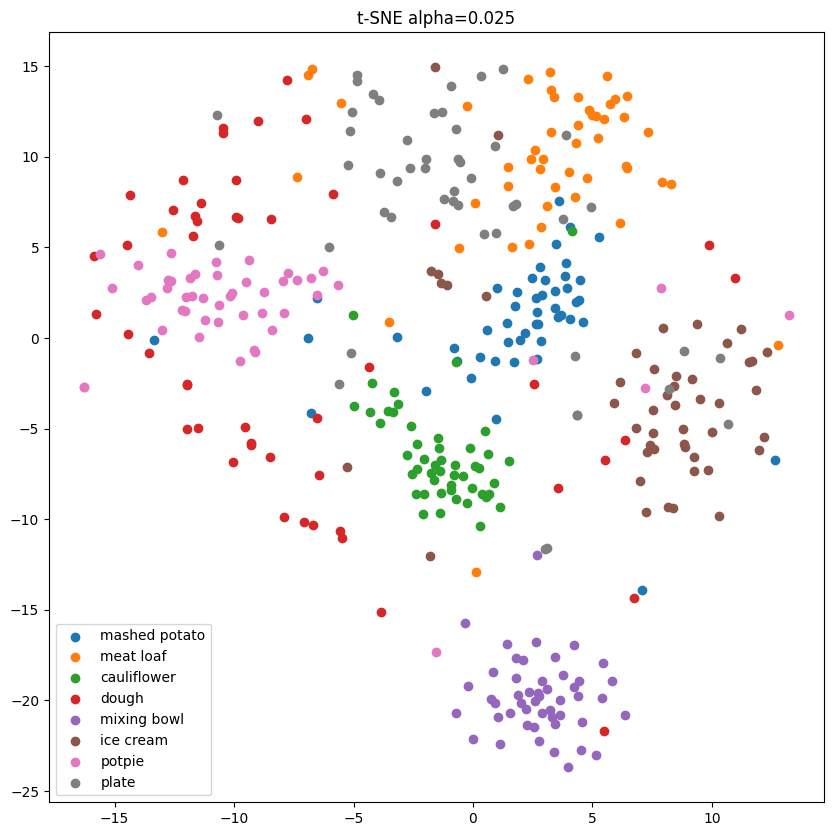

In [40]:
tsne_alpha = ALPHA_TO_TEST[1]
tsne_classes = get_top_k(counters[tsne_alpha], 8).keys()
plot_classes_tsne(get_latent_classes(model, test_dataset, tsne_classes, DEVICE), f"t-SNE alpha={tsne_alpha}", save_path)

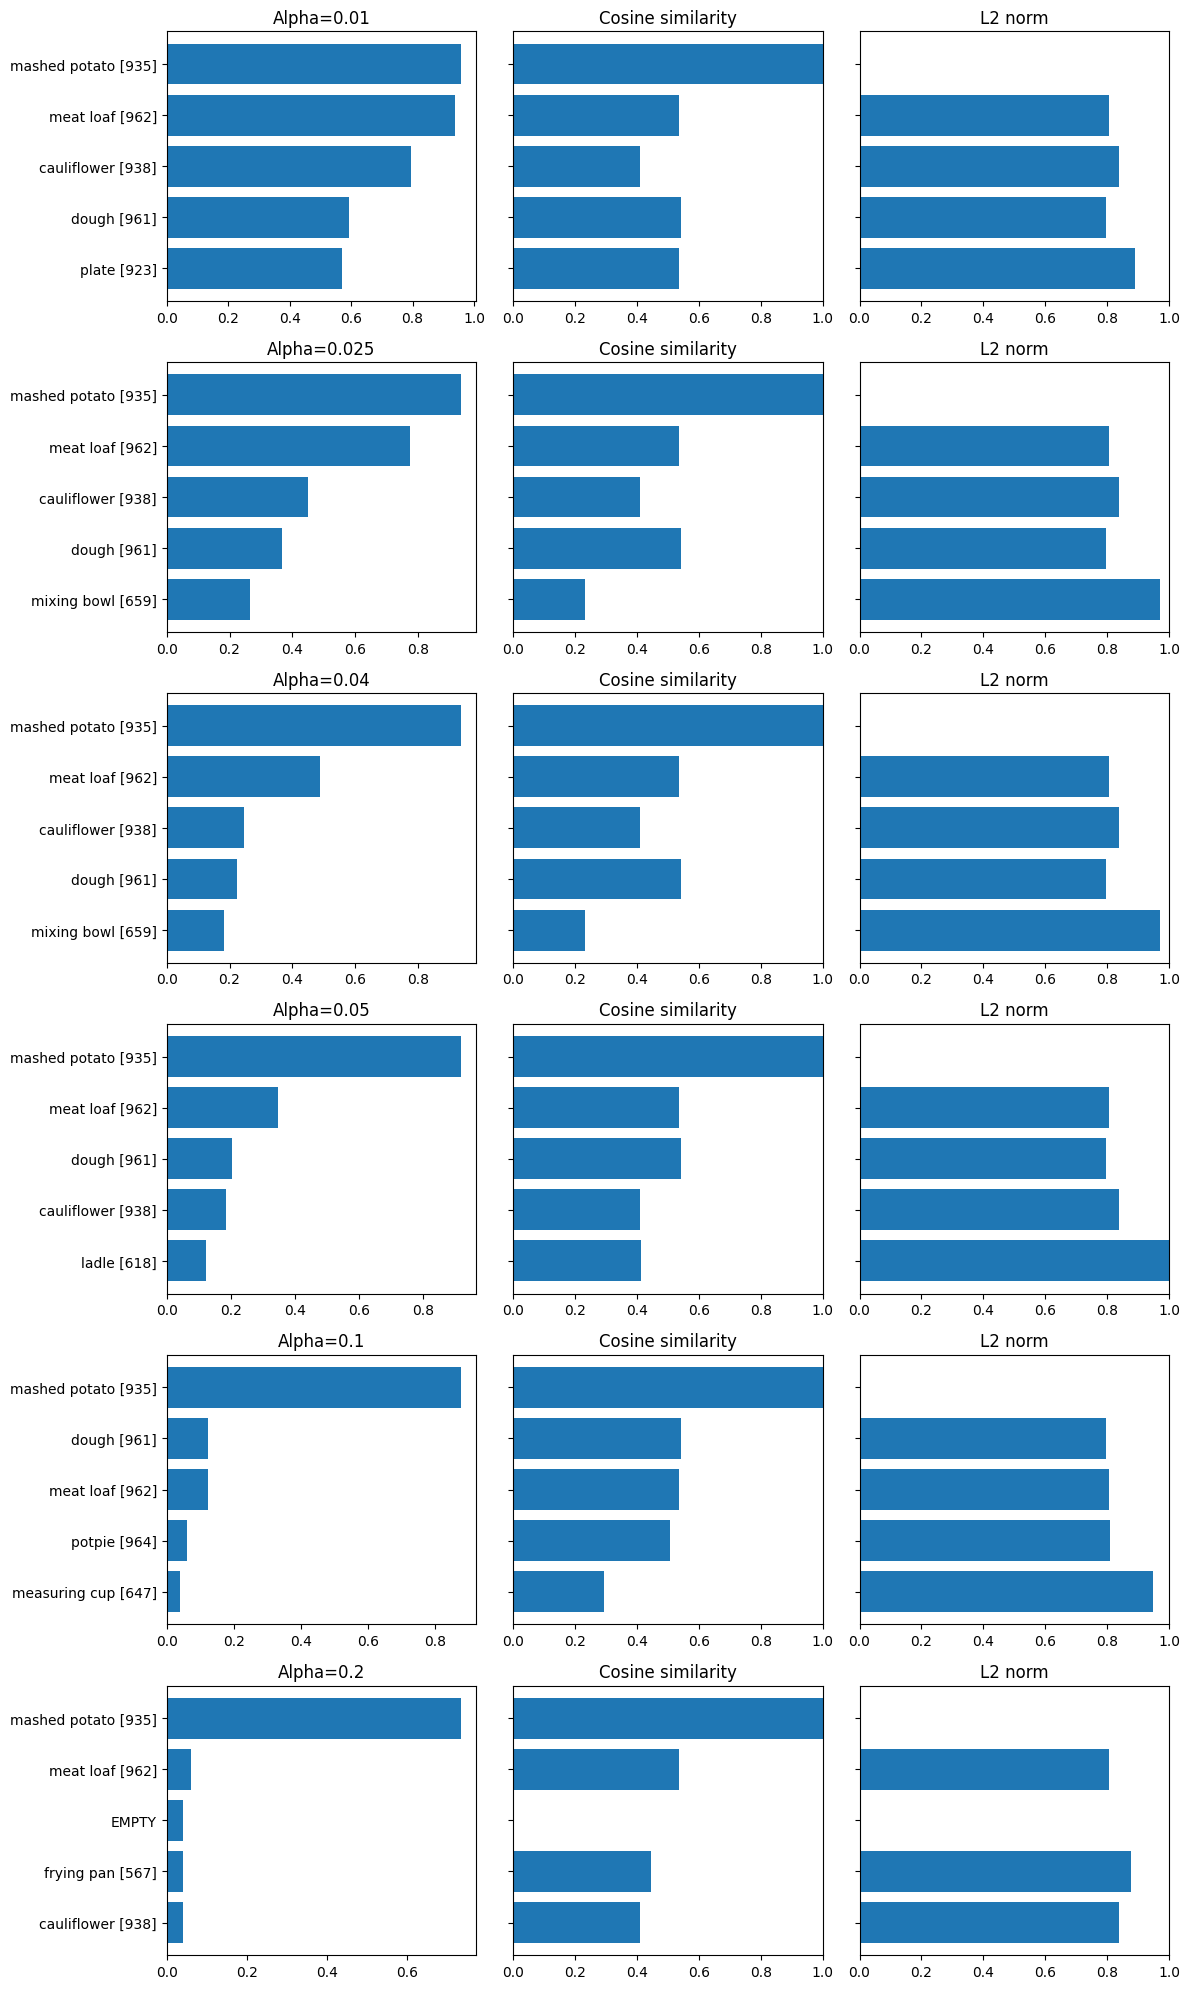

/mnt/d/Tomasz/Pulpit/Trustworthy/conformal_bias_detection/plot_utils.py:117: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


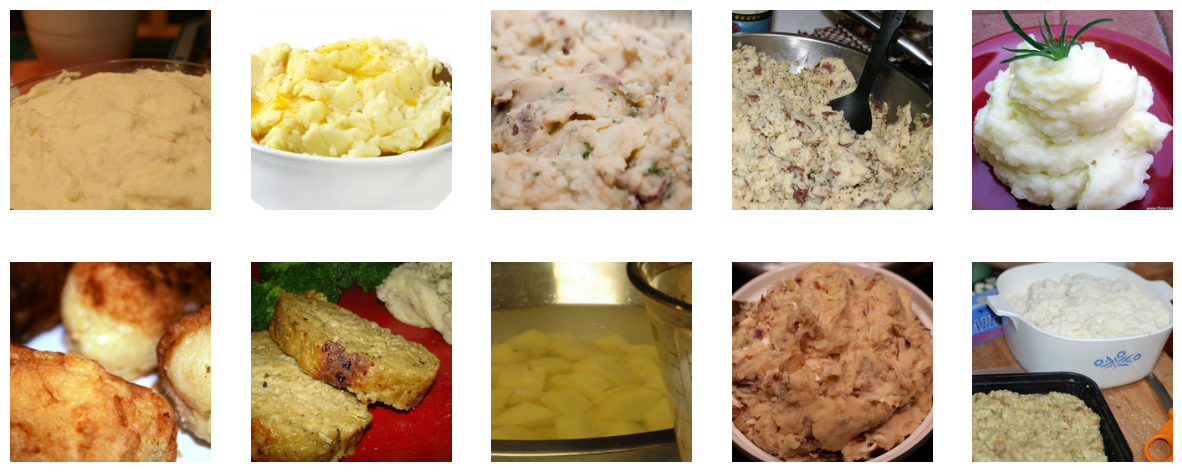

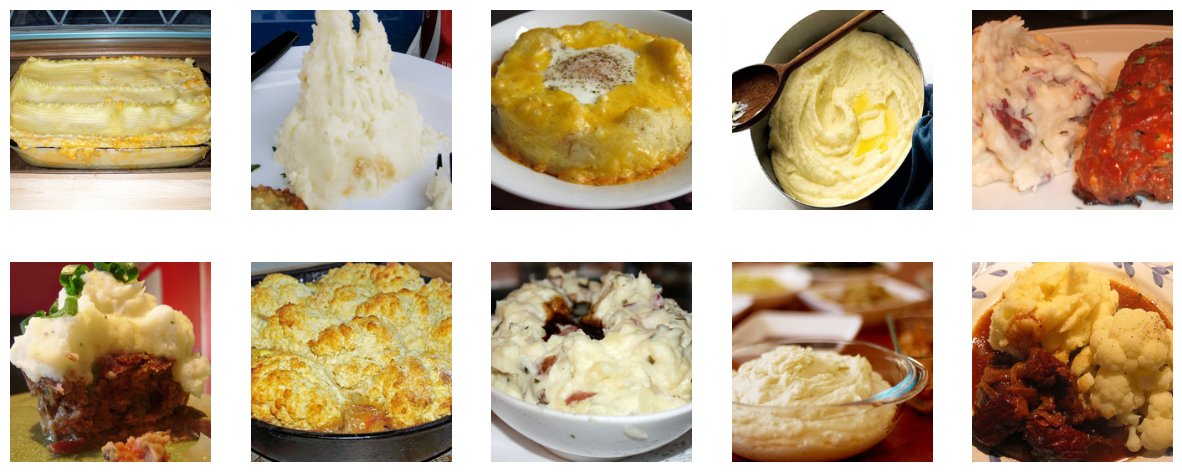

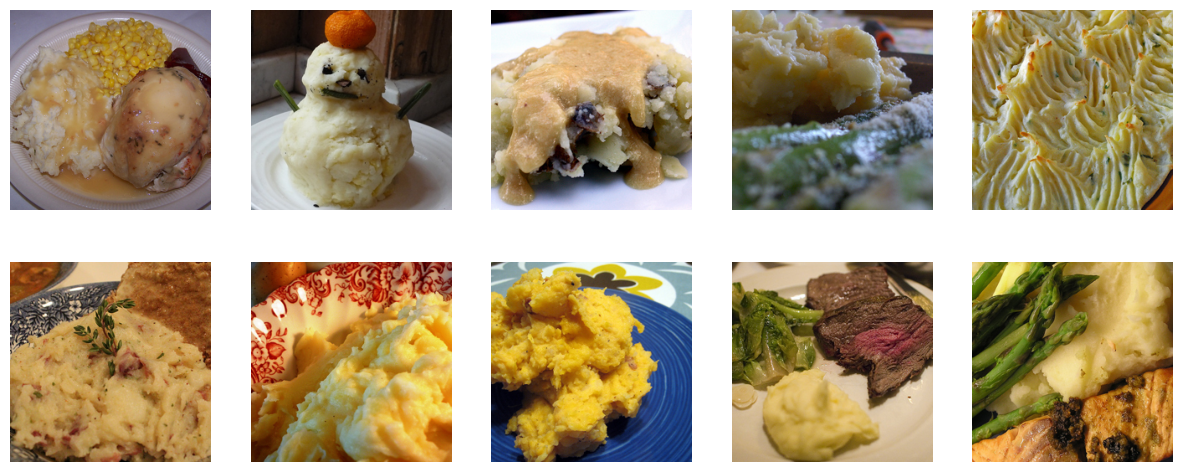

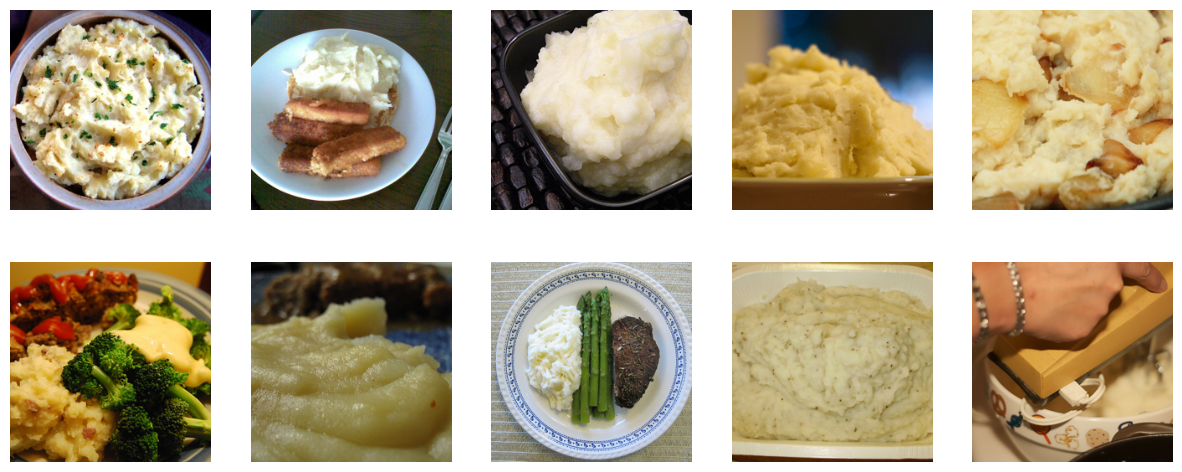

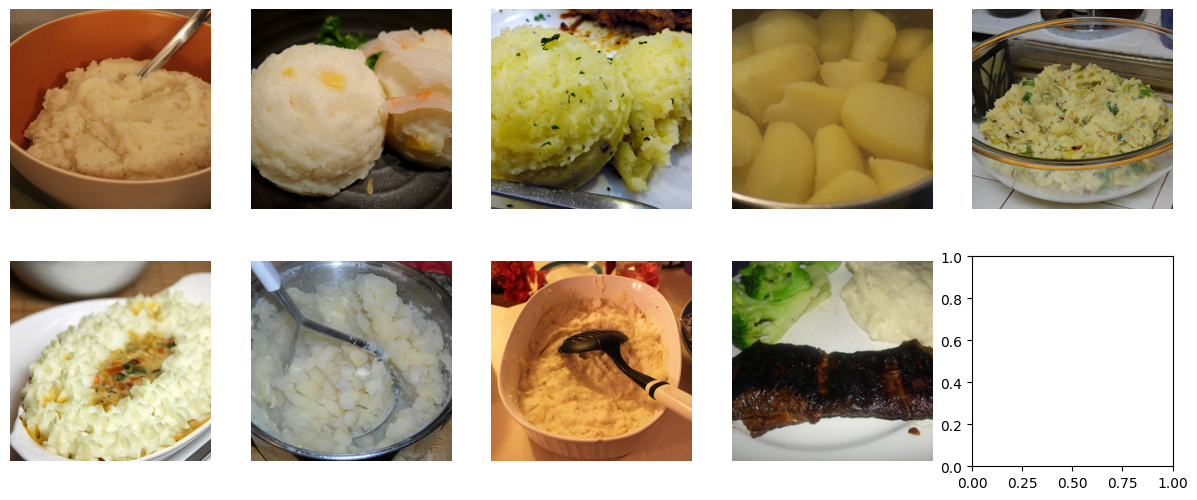

In [41]:

plot_experiment_results(
    CLASS, top_k_counters, latent_classes, model_name, class_subset, save_path
)